In [1]:
pip install causalml pandas numpy scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from causalml.inference.meta import BaseDRLearner, BaseXLearner

In [3]:
# 1. Loading and preparing data
df = pd.read_csv('/content/df_new.csv')
print("Initial shape:", df.shape)

# Robust Quarter → int
if pd.api.types.is_numeric_dtype(df['Quarter']):
    df['QuarterInt'] = df['Quarter'].astype(int)
else:
    df['QuarterInt'] = (df['Quarter']
                       .astype(str)
                       .str.replace('Q','', regex=False)
                       .astype(int))

# next-quarter ACR
df = df.sort_values(['Provider','Year','QuarterInt'])
df['ACR_next'] = df.groupby('Provider')['ACR'].shift(-1)


# Note: CausalML only takes discrete data
# Binary treatment: 1 if increases, else 0
df['treatment'] = (df['ACR_next'] > df['ACR']).astype(int)

# Dropping the missing values
df_model = df.dropna(subset=['treatment','ChurnRate']).copy()
print("After dropna:", df_model.shape)

Initial shape: (3276, 17)
After dropna: (3276, 17)


In [18]:
df.columns

Index(['Year', 'Provider', 'Quarter', 'Members', 'ACR', 'RiskFactor',
       'Regionality', 'Members_Lag', 'Rate_Lag', 'ChurnRate', 'Treatment',
       'QuarterInt', 'ACR_next', 'treatment', 'CATE_DR', 'CATE_XL',
       'Quarter_Since_Start'],
      dtype='object')

In [19]:
df.head()

,Year,Provider,Quarter,Members,ACR,RiskFactor,Regionality,Members_Lag,Rate_Lag,ChurnRate,Treatment,QuarterInt,ACR_next,treatment,CATE_DR,CATE_XL,Quarter_Since_Start
0,2016,AOK Baden-Württemberg,2,3108506,1.0,1.001319,Regional,3081619.0,1.0,-0.008725,0,2,1.0,0,0.002995,-0.001274,2
1,2016,AOK Baden-Württemberg,3,3137197,1.0,1.001319,Regional,3108506.0,1.0,-0.009230,0,3,1.0,0,0.002244,0.002332,3
2,2016,AOK Baden-Württemberg,4,3175380,1.0,1.001319,Regional,3137197.0,1.0,-0.012171,0,4,1.0,0,0.006307,0.004113,4
3,2017,AOK Baden-Württemberg,1,3197300,1.0,0.985325,Regional,3175380.0,1.0,-0.006903,0,1,1.0,0,-0.000855,0.001949,5
4,2017,AOK Baden-Württemberg,2,3219811,1.0,0.985325,Regional,3197300.0,1.0,-0.007041,0,2,1.0,0,0.002288,-0.001541,6


In [13]:
# Features, treatment, outcome
X = df_model[[
    'Quarter_Since_Start',
    'Rate_Lag',
    'Members_Lag',
    'RiskFactor'
]]
T = df_model['treatment'].values
y = df_model['ChurnRate'].values
X_values = X.values

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



DR-Learner ATE (↑ vs no-↑): -0.00387


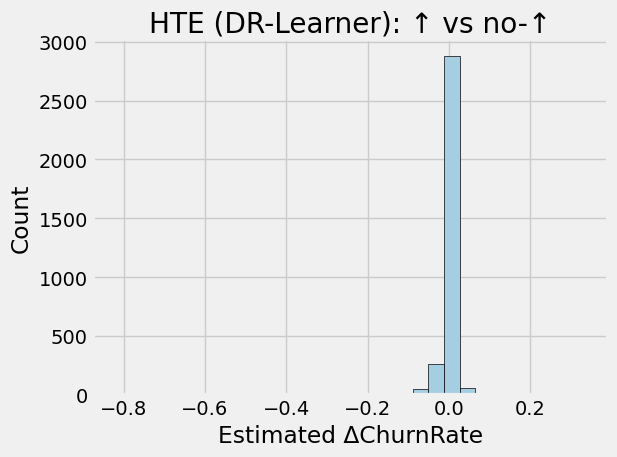

In [14]:

# 2. Fitting DR-Learner and get ATE, CATE, HTE
dr = BaseDRLearner(learner=RandomForestRegressor(random_state=42))
dr.fit(X_values, T, y)

# predicting returns (n_samples, n_treatments_minus_control)= (n,1) here
te_dr = dr.predict(X_values)[:, 0]
df_model['CATE_DR'] = te_dr
ate_dr = te_dr.mean()
print(f"\nDR-Learner ATE (Increase ↑ vs no increase (no-↑)): {ate_dr:.5f}")

# HTE histogram
plt.figure()
plt.hist(te_dr, bins=30, edgecolor='k')
plt.title('HTE (DR-Learner): ↑ vs no-↑')
plt.xlabel('Estimated ΔChurnRate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [20]:
## UNDERSTANDING THE RESULTS

# An ATE of –0.00263 means that, on average across all provider‐quarters in your sample, when the average contribution rate (ACR) increases from one quarter to the next (​treatment=1) rather than stays the same or decreases (treatment=0), the churn rate falls by 0.00263 in absolute terms.
	# •	Since your churn rate is measured as a proportion (e.g. 0.05 = 5%), a change of –0.00263 corresponds to a 0.263 percentage‐point reduction in churn.
	# •	In practical terms, if you had 10 000 members, you’d expect about 26 fewer churns on average when you raise ACR, compared to not raising it.

In [21]:
import pandas as pd

hte_series = pd.Series(te_dr, name='HTE_DR')
df_model['HTE_DR'] = hte_series

# HTE numerical analysis
print("All HTE values:")
print(hte_series.values)

print("\nHTE summary statistics:")
print(hte_series.describe())

print("\nTop 5 HTE values:")
print(hte_series.nlargest(5).values)

print("\nBottom 5 HTE values:")
print(hte_series.nsmallest(5).values)

df_model[['Provider', 'Quarter_Since_Start', 'HTE_DR']].to_csv('hte_dr_results.csv', index=False)


All HTE values:
[-0.00037349  0.00115086  0.00123615 ...  0.00862899 -0.00262925
 -0.00568758]

HTE summary statistics:
count    3276.000000
mean       -0.003874
std         0.029137
min        -0.818402
25%        -0.007192
50%        -0.003902
75%        -0.000240
max         0.333498
Name: HTE_DR, dtype: float64

Top 5 HTE values:
[0.33349808 0.24943758 0.22020336 0.21792313 0.20783931]

Bottom 5 HTE values:
[-0.81840243 -0.75469098 -0.32044575 -0.27418775 -0.18965981]


In [15]:
print("First few CATEs:\n", df_model['CATE_DR'].head())
print("\nCATE summary:\n", df_model['CATE_DR'].describe())

First few CATEs:
 0   -0.000373
1    0.001151
2    0.001236
3    0.001492
4    0.001047
Name: CATE_DR, dtype: float64

CATE summary:
 count    3276.000000
mean       -0.003874
std         0.029137
min        -0.818402
25%        -0.007192
50%        -0.003902
75%        -0.000240
max         0.333498
Name: CATE_DR, dtype: float64


ROBUSTNESS CHECKS


X-Learner ATE (↑ vs no-↑): -0.00343


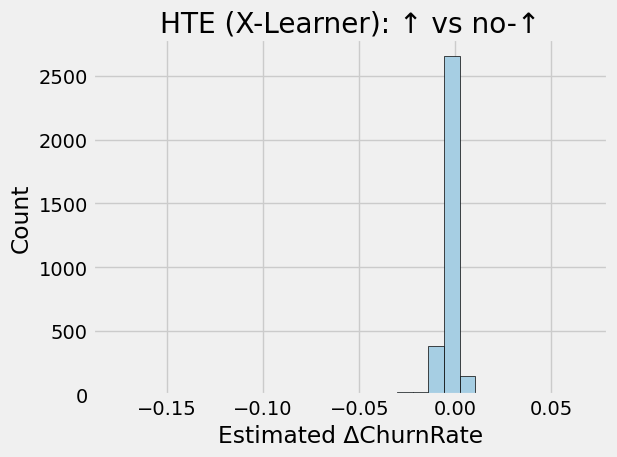

In [16]:
from sklearn.linear_model import LogisticRegression
from causalml.inference.meta import BaseXLearner
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 3. Sensitivity check #1: X-Learner (with dict of propensities)

#  Fitting a logistic model to get P(T=1|X) and P(T=0|X)
ps_model = LogisticRegression(max_iter=1000, random_state=42)
ps_model.fit(X_values, T)
proba = ps_model.predict_proba(X_values)   # shape = (n_samples, 2)

# Building a dict: level:: P(T=level|X)
#    ps_model.classes_ is [0, 1], and proba[:,0] is P(T=0), proba[:,1] is P(T=1)
p_dict = {cls: proba[:, i] for i, cls in enumerate(ps_model.classes_)}

# Here we are instantiating and fitting the X-Learner and passing in p_dict
xl = BaseXLearner(learner=RandomForestRegressor(random_state=42))
xl.fit(X_values, T, y, p=p_dict)

# Predict the CATEs (treatment=1 vs control=0)
te_xl = xl.predict(X_values, p=p_dict)[:, 0]
df_model['CATE_XL'] = te_xl
ate_xl = te_xl.mean()
print(f"\nX-Learner ATE (↑ vs no-↑): {ate_xl:.5f}")

# Lastly plotting the HTE distribution
plt.figure()
plt.hist(te_xl, bins=30, edgecolor='k')
plt.title('HTE (X-Learner): ↑ vs no-↑')
plt.xlabel('Estimated ΔChurnRate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



In [17]:
df_model.to_csv('df_model.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


Placebo ATE (shuffled T): -0.00065


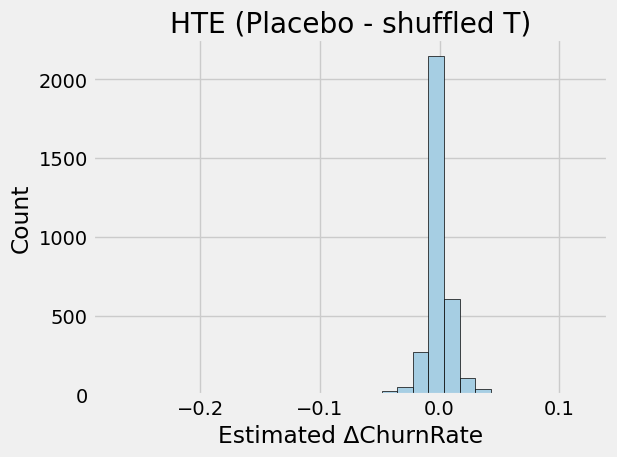

In [12]:

# 4. Placebo check: shuffle treatment
T_placebo = np.random.permutation(T)
dr_placebo = BaseDRLearner(learner=RandomForestRegressor(random_state=42))
dr_placebo.fit(X_values, T_placebo, y)
te_placebo = dr_placebo.predict(X_values)[:, 0]
ate_placebo = te_placebo.mean()
print(f"\nPlacebo ATE (shuffled T): {ate_placebo:.5f}")

plt.figure()
plt.hist(te_placebo, bins=30, edgecolor='k')
plt.title('HTE (Placebo - shuffled T)')
plt.xlabel('Estimated ΔChurnRate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



DR ATE without RiskFactor: -0.00409


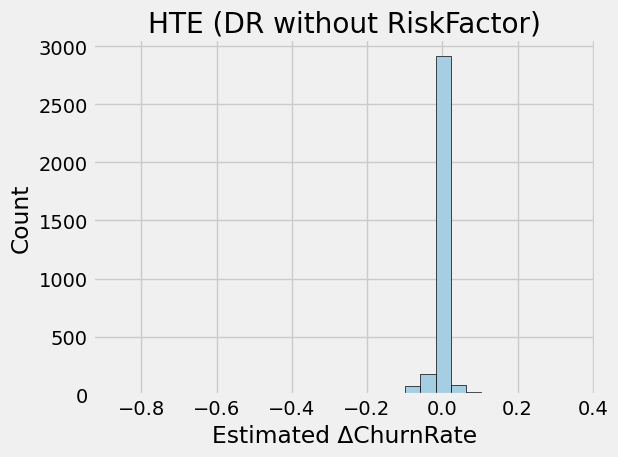

In [10]:
# 5. Sensitivity #2: dropping the RiskFactor and re-estimate DR
X_norf = X.drop(columns=['RiskFactor']).values
dr_norf = BaseDRLearner(learner=RandomForestRegressor(random_state=42))
dr_norf.fit(X_norf, T, y)
te_norf = dr_norf.predict(X_norf)[:, 0]
ate_norf = te_norf.mean()
print(f"\nDR ATE without RiskFactor: {ate_norf:.5f}")

plt.figure()
plt.hist(te_norf, bins=30, edgecolor='k')
plt.title('HTE (DR without RiskFactor)')
plt.xlabel('Estimated ΔChurnRate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [30]:
print(np.unique(T))

[0 1]
